<a href="https://colab.research.google.com/github/crea0414/1st_CVDL/blob/master/Build_SSD_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My\ Drive/First_CV_DL191125/Object\ Detection\ 程式導讀

/gdrive/My Drive/First_CV_DL191125/Object Detection 程式導讀


In [3]:
from ssd import build_ssd
from layers.box_utils import *
import os
import sys
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse
import torchvision
import pickle
from layers import box_utils
from layers import Detect
from layers import functions
from layers import modules
import torch.nn.functional as F
from math import sqrt as sqrt
from itertools import product as product

from torch.autograd import Function
from layers.box_utils import decode, nms

In [4]:
## 詳細模型結構可以參考ssd.py
ssd_net=build_ssd('train', size=300, num_classes=21)
ssd_net.load_weights('./demo/ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...
Finished!


## 默認Config檔案在data/config.py內

In [5]:
ssd_net.cfg

{'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
 'clip': True,
 'feature_maps': [38, 19, 10, 5, 3, 1],
 'lr_steps': (80000, 100000, 120000),
 'max_iter': 120000,
 'max_sizes': [60, 111, 162, 213, 264, 315],
 'min_dim': 300,
 'min_sizes': [30, 60, 111, 162, 213, 264],
 'name': 'VOC',
 'num_classes': 21,
 'steps': [8, 16, 32, 64, 100, 300],
 'variance': [0.1, 0.2]}

In [6]:
cfg = {
    'num_classes': 21,
    'lr_steps': (80000, 100000, 120000),
    'max_iter': 120000,
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'min_dim': 300,
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes': [30, 60, 111, 162, 213, 264],
    'max_sizes': [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    'variance': [0.1, 0.2],
    'clip': True,
    'name': 'VOC',
}

### 'aspect_ratios' : 使用六張Feature Map，每一張上方有預設的anchor boxes，Boxes aspect ratio可以自己設定
### 'feature_maps' : 使用feature map大小為[38x38, 19x19, 10x10, 5x5, 3x3, 1x1]
### 'min_sizes'、'max_sizes'可藉由下方算式算出，由作者自行設計
### 'steps' : Feature map回放回原本300*300的比例，如38要回放為300大概就是8倍
### 'variance' : Training 的一個trick，加速收斂，詳見：https://github.com/rykov8/ssd_keras/issues/53

---

## 'min_sizes'、'max_sizes' 計算

- 計算在6個不同feature maps的anchor boxes 最小最大是多少
- 以縮放率最小10%到最大90%(20%-90%)Range對6個feature maps間的間隔數(6-1)進行線性區分
- 定義最大張feature maps的最小最大anchor boxes為(10%, 20%)起始點, 次大張的為(20%, 37%), (37%, 54%), (54%, 71%), (71%, 88%), (88%, 105%)

In [7]:
import math
## source:https://blog.csdn.net/gbyy42299/article/details/81235891
min_dim = 300   ## 维度
# conv4_3 ==> 38 x 38
# fc7 ==> 19 x 19
# conv6_2 ==> 10 x 10
# conv7_2 ==> 5 x 5
# conv8_2 ==> 3 x 3
# conv9_2 ==> 1 x 1
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2'] ## prior_box來源層，可以更改。很多改進都是基於此處的調整。
# in percent %
min_ratio = 20 ## 這裡即是論文中所說的Smin的= 0.2，Smax的= 0.9的初始值，經過下面的運算即可得到min_sizes，max_sizes。
max_ratio = 90
step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))## 取一個間距步長，即在下面用於循環給比取值時起一個間距作用。可以用一個具體的數值代替，這裡等於17。
min_sizes = []  ## 經過以下運算得到min_sizes和max_sizes。
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
    ## 從min_ratio至max_ratio + 1每隔步驟= 17取一個值賦值給比。注意範圍函數的作用。
    ## min_sizes.append（）函數即把括號內部每次得到的值依次給了min_sizes。
    print(f'min_step: {ratio}, max_step: {ratio+step}')
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 10 / 100.] + min_sizes
max_sizes = [min_dim * 20 / 100.] + max_sizes

## steps: 這一步要仔細理解，即計算卷積層產生的prior_box距離原圖的步長，先驗框中心點的坐標會乘以step，
## 相當於從特徵映射位置映射回原圖位置，比如conv4_3輸出特徵圖大小為38 *38，而輸入的圖片為300* 300，
## 所以38 *8約等於300，所以映射步長為8.這是針對300* 300的訓練圖片。
steps = [8, 16, 32, 64, 100, 300]  
aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]
 
print('min_sizes: ',min_sizes)
print('max_sizes: ',max_sizes)


min_step: 20, max_step: 37
min_step: 37, max_step: 54
min_step: 54, max_step: 71
min_step: 71, max_step: 88
min_step: 88, max_step: 105
min_sizes:  [30.0, 60.0, 111.0, 162.0, 213.0, 264.0]
max_sizes:  [60.0, 111.0, 162.0, 213.0, 264.0, 315.0]


---

## Steps 算是原圖與各個feature maps長度單位比例(如下)

In [8]:
#'steps': [8, 16, 32, 64, 100, 300],
feature_maps = [38, 19, 10, 5, 3, 1]
origin_size = 300
for f in feature_maps:
    print(np.round(origin_size/f, 0))

8.0
16.0
30.0
60.0
100.0
300.0


## Default anchor boxes設計原理，看懂收穫很多
##### 可以理解 SSD原文中 8732個anchors是怎麼來的
##### 38×38×4+19×19×6+10×10×6+5×5×6+3×3×4+1×1×4=8732

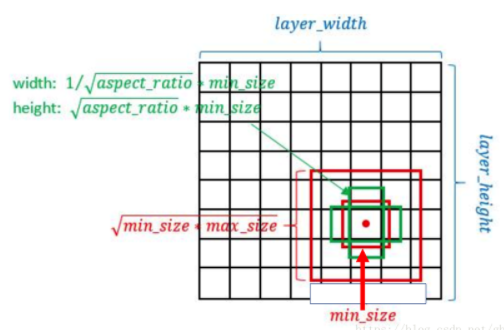

In [9]:
class PriorBox(object):
    """Compute priorbox coordinates in center-offset form for each source
    feature map.
    """
    def __init__(self, cfg):
        super(PriorBox, self).__init__()
        self.image_size = cfg['min_dim']
        # number of priors for feature map location (either 4 or 6)
        self.num_priors = len(cfg['aspect_ratios'])
        self.variance = cfg['variance'] or [0.1]
        self.feature_maps = cfg['feature_maps']
        self.min_sizes = cfg['min_sizes']
        self.max_sizes = cfg['max_sizes']
        self.steps = cfg['steps']
        self.aspect_ratios = cfg['aspect_ratios']
        self.clip = cfg['clip']
        self.version = cfg['name']
        for v in self.variance:
            if v <= 0:
                raise ValueError('Variances must be greater than 0')

    def forward(self):
        mean = []
        '''依照Feature map大小找出所有的pixel 中心'''
        '''下方這兩個loop會找出W個x軸pixel對上W個y軸pixel，假如現在是在38x38的feature map上，就會有38x38個值'''
        '''ex. [0,1],[0,2]..[0,37] [1,1],[1,2]..[1,37]..........[37,37]'''
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):
                f_k = self.image_size / self.steps[k] ## 如self.steps==8，就是先將原圖size normalize(/300)後再乘上8
                #[crea]:f_k 等於是換算成feature map的浮點數版本
                # unit center x,y
                '''中心點'''
                #[crea]: i, j 等於是以feature maps坐標系給出各個cell的座標, 平移到中心點後，除以f_k(精準版的)feature map size Nomarlized 成單位座標(0-1)
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # aspect_ratio: 1
                # rel size: min_size
                '''/self.image_size 就是在做normalization '''
                #[crea]: 把每個feature map的小anchor box長度進行歸一(下方有大的anchor box長度算法跟小的不一樣當aspect_ration為1)
                s_k = self.min_sizes[k]/self.image_size
                '''小的正方形box'''
                mean += [cx, cy, s_k, s_k]

                # aspect_ratio: 1
                # rel size: sqrt(s_k * s_(k+1))
                #[crea]: s_(k+1) 大anchor box也是進行歸一後，與小anchor box相乘開根號
                '''大的正方形box'''
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # rest of aspect ratios
                for ar in self.aspect_ratios[k]:
                    '''aspect ratio 2,3'''
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    '''aspect ratio 1/2,1/3'''
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]
        # back to torch land
        output = torch.Tensor(mean).view(-1, 4)
        if self.clip:
            output.clamp_(max=1, min=0)
        return output

In [10]:
PriorBox_Demo=PriorBox(cfg)
print(PriorBox_Demo.forward().shape)

torch.Size([8732, 4])


---

## Loss 如何設計

In [29]:
#!ls layers/modules/

__init__.py  l2norm.py	multibox_loss.py  __pycache__


In [12]:
#%pycat layers/box_utils.py

In [13]:
#%pycat ssd.py

In [30]:
#%pycat layers/modules/multibox_loss.py

### CrossEntropy 特性與數值穩定算法

In [11]:
'''Logits數值加減後，再經過softmax計算都是相同的'''
logits = torch.tensor([3., 1, -3])
logits_1 = logits - logits.max()
print(f'logits:{logits}\nlogits_1:{logits_1}')
print(f'softmax:{torch.nn.functional.softmax(logits, dim=-1)}')
print(f'softmax_1:{torch.nn.functional.softmax(logits_1, dim=-1)}')

logits:tensor([ 3.,  1., -3.])
logits_1:tensor([ 0., -2., -6.])
softmax:tensor([0.8789, 0.1189, 0.0022])
softmax_1:tensor([0.8789, 0.1189, 0.0022])


In [12]:
batch_nums = 3
classes = 5
w_h = 2
initial_num_range = 1000

logits = torch.tensor(np.random.randint(0, initial_num_range, (batch_nums, classes, w_h, w_h)), dtype=torch.float32)
labels = torch.tensor(np.random.randint(0, classes, (batch_nums, 1, w_h, w_h)), dtype=torch.int64)
probs = torch.nn.functional.softmax(logits, dim=1)
probs.shape, labels.shape

(torch.Size([3, 5, 2, 2]), torch.Size([3, 1, 2, 2]))

In [13]:
batch_logits = logits.view(logits.size(0)*w_h*w_h, -1) 
batch_labels = labels.view(labels.size(0)*w_h*w_h)
batch_logits.size(), batch_labels.size()

(torch.Size([12, 5]), torch.Size([12]))

In [14]:
batch_logits[:6], batch_labels[:6]

(tensor([[666., 466., 994., 945., 647.],
         [728., 665., 756., 847., 274.],
         [972.,  17.,  56., 668., 204.],
         [189., 593., 184., 388., 233.],
         [856., 921., 766., 457., 772.],
         [678.,   8., 935., 948., 459.]]), tensor([4, 4, 4, 3, 0, 2]))

In [15]:
batch_max, _ = torch.max(batch_logits, dim=1, keepdim=True)
batch_max.size()

torch.Size([12, 1])

In [16]:
'''Logits 做exp計算時，容易造成overflow or underflow(過大inf/過小0)，最好將logits減掉其元素內最大值使其操作exp時數值穩定'''
#batch_max = 0
batch_exp = torch.exp(batch_logits-batch_max)
batch_log_sum = torch.log(torch.sum(batch_exp, dim=1, keepdim=True)) + batch_max
batch_class = batch_logits.gather(1, batch_labels.view(batch_labels.size(0), -1))
print(f'batch_exp:{batch_exp}')
print(f'batch_log_sum:{batch_log_sum}')
print(f'batch_class:{batch_class}')

batch_exp:tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 5.2429e-22, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.0144e-40, 1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.9001e-29, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.2603e-06, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.2664e-14, 0.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.7588e-25, 0.0000e+00, 3.4425e-14, 0.0000e+00],
        [5.7495e-19, 1.4013e-44, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
batch_log_sum:tensor([[994.],
        [847.],
        [972.],
        [593.],
        [921.],
        [948.],
        [891.],
        [651.],
       

In [17]:
batch_loss = batch_log_sum - batch_class
print(f'batch_loss:{batch_loss.view(-1)}')
print(f'cross_entropy:{torch.nn.functional.cross_entropy(batch_logits, batch_labels, reduction="none")}')
print(f'mean_batch_loss:{torch.mean(batch_loss)}')
print(f'mean_cross_entropy:{torch.nn.functional.cross_entropy(batch_logits, batch_labels, reduction="mean")}')

batch_loss:tensor([347., 573., 768., 205.,  65.,  13.,  32.,   0., 122., 227., 740., 341.])
cross_entropy:tensor([347.0000, 573.0000, 768.0000, 205.0000,  65.0000,  13.0000,  32.0000,
         -0.0000, 122.0000, 227.0000, 740.0000, 341.0000])
mean_batch_loss:286.0833435058594
mean_cross_entropy:286.0833435058594


In [18]:
batch_loss.size()

torch.Size([12, 1])

In [19]:
batch_loss.sort(dim=1, descending=True)

torch.return_types.sort(values=tensor([[347.],
        [573.],
        [768.],
        [205.],
        [ 65.],
        [ 13.],
        [ 32.],
        [  0.],
        [122.],
        [227.],
        [740.],
        [341.]]), indices=tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]]))

In [20]:
class MultiBoxLoss(nn.Module):

    def __init__(self, num_classes, overlap_thresh, prior_for_matching,
                 bkg_label, neg_mining, neg_pos, neg_overlap, encode_target,
                 use_gpu=True):
        super(MultiBoxLoss, self).__init__()
        self.use_gpu = use_gpu
        '''有幾類別'''
        self.num_classes = num_classes
        '''判定為正樣本的threshold，一般設為0.5'''
        self.threshold = overlap_thresh
        '''background自己會有一類，不用Label，假如我們有20類一樣標註0-19，下方會自己空出一類給background'''
        self.background_label = bkg_label
        self.encode_target = encode_target
        self.use_prior_for_matching = prior_for_matching
        '''OHEM，找出分得最不好的樣品，也就是confidence score比較低的正負樣品'''
        self.do_neg_mining = neg_mining
        '''負樣品與正樣品的比例，通常是3:1'''
        self.negpos_ratio = neg_pos
        self.neg_overlap = neg_overlap
        self.variance = cfg['variance']
     

    def forward(self, predictions, targets):

        '''prediction會output三個值'''
        '''loc shape: bounding box 資訊，torch.size(batch_size,num_priors,4)'''
        '''conf shape: 每一個bounding box 的信心程度，torch.size(batch_size,num_priors,num_classes)'''
        '''priors shape: 預設的defaul box， torch.size(num_priors,4)'''
        loc_data, conf_data, priors = predictions
        print(f'loc_data:{loc_data.size()}\nconf_data:{conf_data.size()}\npriors:{priors.size()}')
        num = loc_data.size(0)
        priors = priors[:loc_data.size(1), :]
        num_priors = (priors.size(0))
        num_classes = self.num_classes

        # match priors (default boxes) and ground truth boxes
        loc_t = torch.Tensor(num, num_priors, 4)
        loc_t.requires_grad_ = False
        conf_t = torch.LongTensor(num, num_priors)
        conf_t.requires_grad_ =False
        for idx in range(num):
            truths = targets[idx][:, :-1].data
            labels = targets[idx][:, -1].data
            defaults = priors.data
            '''jaccard 計算每一個BBOX與ground truth的IOU'''
            match(self.threshold, truths, defaults, self.variance, labels,
                  loc_t, conf_t, idx)
        if self.use_gpu:
            loc_t = loc_t.cuda()
            conf_t = conf_t.cuda()
        '''用Variable包裝'''
        #loc_t = Variable(loc_t, requires_grad=False)
        #conf_t = Variable(conf_t, requires_grad=False)

        pos = conf_t > 0 #(batch_size, num_priors)
        num_pos = pos.sum(dim=1, keepdim=True) #(batch_size, 1)


        pos_idx = pos.unsqueeze(pos.dim()).expand_as(loc_data) #(batch_size, num_priors, 4) same as loc_data.size()
        loc_p = loc_data[pos_idx].view(-1, 4)  #(batch_size*num_priors, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)     #(batch_size*num_priors, 4)
        '''smooth_l1_loss 計算bounding box regression'''
        #loss_l = F.smooth_l1_loss(loc_p, loc_t, size_average=False)
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # Compute max conf across batch for hard negative mining
        batch_conf = conf_data.view(-1, self.num_classes) #(batch_size*num_priors, num_classes)
        loss_c = log_sum_exp(batch_conf) - batch_conf.gather(1, conf_t.view(-1, 1)) 
        #conf_t(batch_size, num_priors) >> conf_t.view(-1, 1):(batch_size*num_priors, 1)
        #log_sum_exp() : close to torch.nn.logSoftmax(), but is not exactly same.
        # why log_sum_exp()https://blog.csdn.net/m0_37477175/article/details/79686164


        # Hard Negative Mining
        loss_c = loss_c.view(num, -1)#(batch_size, num_priors)
        loss_c[pos] = 0 #remove positive loss


        '''排列negative confidence 的分數'''
        _, loss_idx = loss_c.sort(1, descending=True)#(batch_size, num_priors)
        _, idx_rank = loss_idx.sort(1)#(batch_size, num_priors)
        #loss_idx自己的idx 代表著"對loss的排名"，再對loss_idx值sorting一次則是希望將loss的排名還原到原loss的位置
        num_pos = pos.long().sum(1, keepdim=True)#(batch_size, 1) num_pos per image <= max num_priors 8732
        '''負樣品取出數量 == negpos_ratio*num_pos'''
        num_neg = torch.clamp(self.negpos_ratio*num_pos, max=pos.size(1)-1)#(batch_size, 1)
        # num_neg 3 times and clamp if num_neg larger than 8732(pos.size(1))
        '''產生負樣品的遮罩: 將每一張統計出3倍正樣品的數量(等於負樣品數量)當作閥值當作產生負樣品的boolean mask'''
        '''loss_idx = idx_rank'''
        neg = idx_rank < num_neg.expand_as(idx_rank)

        # Confidence Loss Including Positive and Negative Examples
        pos_idx = pos.unsqueeze(2).expand_as(conf_data) #shape: [batch_size, num_priors, num_classes]
        neg_idx = neg.unsqueeze(2).expand_as(conf_data) #shape: [batch_size, nun_priors, num_classes]
        conf_p = conf_data[(pos_idx+neg_idx).gt(0)].view(-1, self.num_classes) #取出正負1:3的conf_data shape: [batch_size*num_priors, num_classes]
        targets_weighted = conf_t[(pos+neg).gt(0)]#取出正負1:3的conf_t shape: [batch_size, num_priors]
        #完成hard nagitive mining

        '''用cross_entropy做分類'''
        #loss_c = F.cross_entropy(conf_p, targets_weighted, size_average=False)
        loss_c = F.cross_entropy(conf_p, targets_weighted, reduction='sum') #reduction 是sum非mean!! 先加總再留到後面計算出pos num in a batch的總數進行平均
        # Sum of losses: L(x,c,l,g) = (Lconf(x, c) + αLloc(x,l,g)) / N
        #double轉成torch.float64
        N = num_pos.data.sum().double() #sum() over batch_size >> all positive num in a batch
        loss_l = loss_l.double()
        loss_c = loss_c.double()
        loss_l /= N
        loss_c /= N
        return loss_l, loss_c


# 研究兩次Sorting的效果

In [21]:
#預設一組0-10的亂數
a = torch.tensor(np.random.randint(0, 10, (10, 5)))
a

tensor([[4, 3, 9, 0, 9],
        [7, 8, 9, 1, 1],
        [2, 7, 2, 5, 7],
        [0, 6, 8, 5, 5],
        [8, 5, 5, 3, 6],
        [5, 0, 7, 1, 7],
        [6, 9, 6, 6, 3],
        [1, 0, 0, 2, 9],
        [9, 3, 3, 7, 5],
        [7, 9, 4, 0, 0]])

In [22]:
#對這組亂數進行排序(descending)大到小，並取出排序後的值與index
a_sort_value, a_sort_idx = a.sort(1, descending=True)
print(f'sort_value:{a_sort_value}\nsort_idx:{a_sort_idx}')

sort_value:tensor([[9, 9, 4, 3, 0],
        [9, 8, 7, 1, 1],
        [7, 7, 5, 2, 2],
        [8, 6, 5, 5, 0],
        [8, 6, 5, 5, 3],
        [7, 7, 5, 1, 0],
        [9, 6, 6, 6, 3],
        [9, 2, 1, 0, 0],
        [9, 7, 5, 3, 3],
        [9, 7, 4, 0, 0]])
sort_idx:tensor([[2, 4, 0, 1, 3],
        [2, 1, 0, 3, 4],
        [1, 4, 3, 0, 2],
        [2, 1, 3, 4, 0],
        [0, 4, 1, 2, 3],
        [2, 4, 0, 3, 1],
        [1, 0, 2, 3, 4],
        [4, 3, 0, 1, 2],
        [0, 3, 4, 1, 2],
        [1, 0, 2, 3, 4]])


In [23]:
# [Key Concept]排序後的index(a_sort_idx)，本身也是一組序列以及自身的idx，此時自己的idx代表排序後的結果。
# 若將a_sort_idx針對value進行一次排序(小到大)則還原為原tensor的順序，則a_sort_idx自己的idx(非value)還原到原tensor的排名。
a_sort_idx_value, a_sort_idx_rank = a_sort_idx.sort(1)
a_sort_idx_value, a_sort_idx_rank

(tensor([[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4]]), tensor([[2, 3, 0, 4, 1],
         [2, 1, 0, 3, 4],
         [3, 0, 4, 2, 1],
         [4, 1, 0, 2, 3],
         [0, 2, 3, 4, 1],
         [2, 4, 0, 3, 1],
         [1, 0, 2, 3, 4],
         [2, 3, 4, 1, 0],
         [0, 3, 4, 1, 2],
         [1, 0, 2, 3, 4]]))

In [31]:
#確認兩次排序後的對應原序列的排名結果
for idx  in range(len(a)):
    print(f'a   :{a[idx]}\nrank:{a_sort_idx_rank[idx]}')
    print()

a   :tensor([4, 3, 9, 0, 9])
rank:tensor([2, 3, 0, 4, 1])

a   :tensor([7, 8, 9, 1, 1])
rank:tensor([2, 1, 0, 3, 4])

a   :tensor([2, 7, 2, 5, 7])
rank:tensor([3, 0, 4, 2, 1])

a   :tensor([0, 6, 8, 5, 5])
rank:tensor([4, 1, 0, 2, 3])

a   :tensor([8, 5, 5, 3, 6])
rank:tensor([0, 2, 3, 4, 1])

a   :tensor([5, 0, 7, 1, 7])
rank:tensor([2, 4, 0, 3, 1])

a   :tensor([6, 9, 6, 6, 3])
rank:tensor([1, 0, 2, 3, 4])

a   :tensor([1, 0, 0, 2, 9])
rank:tensor([2, 3, 4, 1, 0])

a   :tensor([9, 3, 3, 7, 5])
rank:tensor([0, 3, 4, 1, 2])

a   :tensor([7, 9, 4, 0, 0])
rank:tensor([1, 0, 2, 3, 4])



## Matching >> Prior boxes with Ground Truth boxes
## 匹配的概念簡述:
---
### 為什麼要做匹配?
TBD
### 匹配三元素
### **Prior-Boxes**
- 一個偵測模型可設定PriorBoxes = DefaultBoxes = AnchorBoxes的數量分配。
以SSD來說依照輸出feature maps定義每個feature map上每個cell的prior boxes的數量以及對應的長寬比，總結來說SSD共有6個feature maps對應設計出prior box的數量共8732個。
- **PriorBoxes**: (num_priors, 4) 
- Paper 原文設定**8732**個prior boxes


### **Prediction**
- 兩大輸出: PredBoxes 和 class confidence (預測框和類別信心度)，數量上會和預設的Prior-Boxes一樣(8732)
- **PredBoxes**: (batch_size, num_priors, 4)
- **ClassConfidence**: (batch_size, num_priors, num_classes) 

### **Groud Truth Boxes**

- **Truth-Boxes**: (batch_size, None, 5)(None:每張照片所含的目標數不固定, 4:(box)+1(class))

---
### **如何匹配** >> 覺得匹配應該設計在training pipe之外，在training process會造成矩陣加速器不快

#### Prior Boxes vs Ground Truth Boxes
以一張照片為單位說明:
1. 一張照片預設有prior boxes(8723)大大小小個框和定義的truth boxes(數量不定)交互計算IoU(jaccard index)，找出每個prior box對應到最大IoU 的truth boxes。
2. 將每個prior box對應最大IoU的truth box定義為matches與prior box總數相同共8723 match_truth_box
3. 進行編碼(將truth box與prior box的box中心座標和box寬高準換成相對表示法)
4. 類似第二步中，將每個prior box對應最大IoU的truth box其類別信心度也是共8732個信心度篩選出來，並將這些信心度所對應的IoU做篩選，小於IoU閥值的信心度設為零及代表背景，非零的類別則順勢加一。(0:背景, 1-20:類別)
5. 總共得到Truth boxes對應到Prior Boxes的相對Box座標和類別信心度，共8723個。

---
- 實作中是以一張照片為單位進行匹配，因此批次計算中是以迴圈迭代張張計算(比較沒效率，可以想想batch向量處理的可能性)
---
6. 匹配後，將焦點放到信心度。與truth box匹配過的loc_t可以得知8732個中有那些為零的背景，那些為非零的目標待選者。
7. 捨棄背景保留目標待測框，即為所謂的正樣品。並進行L1_smooth_loss計算

```
def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]          # Shape: [num_priors,4]
    conf = labels[best_truth_idx] + 1         # Shape: [num_priors]
    conf[best_truth_overlap < threshold] = 0  # label as background
    loc = encode(matches, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior
```

## 產生我們Loss function，注意這裡的class要包含背景

In [21]:
Use_cuda=False
criterion = MultiBoxLoss(num_classes=21,
                         overlap_thresh=0.5, 
                         prior_for_matching = True, 
                         bkg_label = 0,
                         neg_mining = False,
                         neg_pos = 3,
                         neg_overlap = 0.5,
                         encode_target = False,
                         use_gpu = Use_cuda,)

----

## 基本設定

In [24]:
ssd_net=build_ssd('train', size=300, num_classes=21)
use_pretrained=False
if use_pretrained:
    ssd_net.load_weights('./demo/ssd300_mAP_77.43_v2.pth')
net=ssd_net

In [25]:
'''要不要使用gpu'''
Use_cuda=False

'''tensor type會依照cpu或gpu有所不同'''
if torch.cuda.is_available():
    if Use_cuda:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if not Use_cuda:
        print("WARNING: It looks like you have a CUDA device, but aren't " +
              "using CUDA.\nRun with --cuda for optimal training speed.")
        torch.set_default_tensor_type('torch.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

'''使用GPU時可以開啟DataParallel，但當Input是不定大小時，要關掉'''
if Use_cuda:
    net = torch.nn.DataParallel(ssd_net)
    cudnn.benchmark = True
'''使用GPU時模型要轉成cuda'''
if Use_cuda:
    net = net.cuda()
    
batch_size_=1
optimizer = optim.Adam(net.parameters(),lr=0.00001/batch_size_)

---

## 訓練

## 這裡我們先示範輸入的 image,Label格式，真正在訓練時，準備成一樣格式即可

In [26]:
'''輸入影像格式，假設batch size 為 4'''
image_in=torch.tensor(torch.rand(4,3,300,300),dtype=torch.float32)
'''Label格式，沒有固定長度，看圖像中有幾個label就有幾個'''
label_0=[[ 0.1804,  0.6076,  0.7701,  0.8485, 0.0000],
       [ 0.2250,  0.0000,  0.9238,  0.5641, 3.0000],
       [ 0.2250,  0.0000,  0.9238,  0.5641, 19.0000],
       [ 0.2950,  0.0000,  0.8238,  0.3641, 6.0000],]
label_1=[[ 0.1804,  0.6076,  0.7701,  0.8485, 13.0000],
       [ 0.2250,  0.0000,  0.9238,  0.5641, 11.0000],
       [ 0.2250,  0.0000,  0.9238,  0.5641, 7.0000],
       [ 0.2950,  0.0000,  0.8238,  0.3641, 5.0000],]
label_2=[[ 0.1804,  0.6076,  0.7701,  0.8485, 0.0000],
       [ 0.2250,  0.0000,  0.9238,  0.5641, 3.0000],
       [ 0.2250,  0.0000,  0.9238,  0.5641, 14.0000],
       [ 0.2950,  0.0000,  0.8238,  0.3641, 6.0000],]
label_3=[[ 0.1804,  0.6076,  0.7701,  0.8485, 0.0000],
       [ 0.2250,  0.0000,  0.9238,  0.5641, 3.0000],
       [ 0.2250,  0.0000,  0.9238,  0.5641, 19.0000],
       [ 0.2950,  0.0000,  0.8238,  0.3641, 6.0000],]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [38]:
epochs=1#300
iteration=10#1000

In [137]:
from tqdm.notebook import tqdm
for epoch in range(epochs):
    n=0
    loss_sum=[]
    loc_loss=[]
    conf_loss=[]
    for number__ in tqdm(range(iteration)):
        '''要用Variable包裝tensor才能送入模型'''
        if Use_cuda:
            image_ = Variable(image_in.cuda())
            y = [Variable(torch.tensor(label_0).cuda(), volatile=True),Variable(torch.tensor(label_1).cuda(), 
                volatile=True),Variable(torch.tensor(label_2).cuda(), volatile=True),Variable(torch.tensor(label_3).cuda(), volatile=True)]      
        else:
            '''
            image_ = Variable(image_in)
            y = [Variable(torch.tensor(label_0), volatile=True),Variable(torch.tensor(label_1), 
                volatile=True),Variable(torch.tensor(label_2), volatile=True),Variable(torch.tensor(label_3), volatile=True)]
            '''
            image_ = image_in.clone().detach().requires_grad_(False)
            y = [torch.tensor(label_0, requires_grad=False), torch.tensor(label_1, requires_grad=False), 
                 torch.tensor(label_2, requires_grad=False), torch.tensor(label_3, requires_grad=False)]

        '''Forward Pass'''
        out = net(image_)
        '''Regression Loss and Classification Loss'''
        loss_l,loss_c = criterion(out,y )
        loss = loss_l+ loss_c
        '''Backward'''
        loss.backward()

        loc_loss.append(loss_l.data.cpu().numpy())
        conf_loss.append(loss_c.data.cpu().numpy())
        loss_sum.append(loss.data.cpu().numpy())
        '''更新參數'''
        optimizer.step()
        '''清空Gradients'''
        optimizer.zero_grad()
        
        n+=1
        if n%10==0:
            print('BBOX Regression Loss: ', np.mean(loc_loss))
            print('Classification Loss: ', np.mean(conf_loss))
    '''儲存權重'''
    #torch.save(ssd_net.state_dict(),'weights/Ｗeights.pth')

loc_data:torch.Size([4, 8732, 4])
conf_data:torch.Size([4, 8732, 21])
priors:torch.Size([8732, 4])
loc_data:torch.Size([4, 8732, 4])
conf_data:torch.Size([4, 8732, 21])
priors:torch.Size([8732, 4])
loc_data:torch.Size([4, 8732, 4])
conf_data:torch.Size([4, 8732, 21])
priors:torch.Size([8732, 4])
loc_data:torch.Size([4, 8732, 4])
conf_data:torch.Size([4, 8732, 21])
priors:torch.Size([8732, 4])
loc_data:torch.Size([4, 8732, 4])
conf_data:torch.Size([4, 8732, 21])
priors:torch.Size([8732, 4])
loc_data:torch.Size([4, 8732, 4])
conf_data:torch.Size([4, 8732, 21])
priors:torch.Size([8732, 4])
loc_data:torch.Size([4, 8732, 4])
conf_data:torch.Size([4, 8732, 21])
priors:torch.Size([8732, 4])
loc_data:torch.Size([4, 8732, 4])
conf_data:torch.Size([4, 8732, 21])
priors:torch.Size([8732, 4])
loc_data:torch.Size([4, 8732, 4])
conf_data:torch.Size([4, 8732, 21])
priors:torch.Size([8732, 4])
loc_data:torch.Size([4, 8732, 4])
conf_data:torch.Size([4, 8732, 21])
priors:torch.Size([8732, 4])
BBOX Regre